In [43]:
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Lambda, Activation, Input, Embedding
import tensorflow.keras.backend as K
import sklearn.preprocessing
import gc
import psutil
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

<h2>Pair-Wise Siamese Network</h2>

In [22]:
intmatrix = np.load("./data/movie-matrix.npz")['data']
mean = np.sum(intmatrix, axis=1)/(intmatrix!=0).sum(axis=1)
zmask = intmatrix==0
intmatrix = intmatrix-mean.reshape(-1,1)
intmatrix[zmask]=0

In [23]:
genre = pd.read_csv("./data/MovieLens/u.item", sep='\t', encoding='latin-1', header=None)
genre = np.array([np.array(s) for s in genre[0].apply(lambda s: np.array(s.split("|"))).values])
genre = genre[:,6:].astype(np.int)

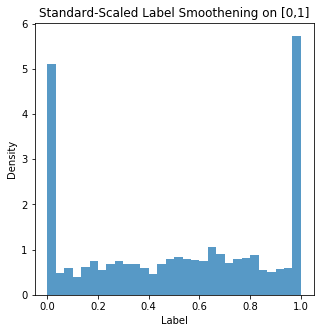

((71951, 3), (17987, 3))

In [24]:
data = pd.DataFrame(intmatrix).stack().reset_index()
data = data[data[0]!=0]
data[0] = (sklearn.preprocessing.StandardScaler().fit_transform(data[[0]])[:,0]+1)/2
data.loc[data[0]>1, 0], data.loc[data[0]<0, 0]= 1, 0
data.columns = ["User", "Item", "Truth"]
plt.figure(figsize=(5,5))
plt.hist(data["Truth"], density=True, alpha=0.75, bins=30)
plt.title("Standard-Scaled Label Smoothening on [0,1]")
plt.xlabel("Label")
plt.ylabel("Density")
plt.show()
np.random.seed(1)
testindex = np.random.choice(data.shape[0], np.int(0.2*data.shape[0]), replace=False)
trainindex = np.array(list(set(np.arange(data.shape[0]))-set(testindex)))
train, test = data.iloc[trainindex], data.iloc[testindex]
train.shape, test.shape

We define the contrastive pair-wise loss used in the network as: <br/>
$L = y \times (1 - \frac{I_1 \cdot I_2}{ ||I_1|| ||I_2||}) + (1-y) \times max(0, C + \frac{I_1 \cdot I_2}{ ||I_1|| ||I_2||}) $ <br/>
where $I_1, I_2$ are the embeddings, $y$ is the smoothened label, and $C$ is a predetermined constant.

In [25]:
def cosine_contrastive_loss(truebin, preddist, C=1):
    return tf.math.reduce_mean(truebin*(1 - preddist) + (1 - truebin)*tf.math.maximum(0.0, C + preddist))

In [26]:
latentdim = 128
userinit = np.random.normal(loc=0, scale=1, size=(intmatrix.shape[0], latentdim))
userinit = userinit/np.sqrt(np.sum(userinit**2, axis=1)).reshape(-1,1)
iteminit = np.random.normal(loc=0, scale=1, size=(intmatrix.shape[1], latentdim))
iteminit = iteminit/np.sqrt(np.sum(iteminit**2, axis=1)).reshape(-1,1)

In [33]:
K.clear_session()
userinput, iteminput = Input((1,)), Input((1,))
#Use fixed 128-length internal vector embeddings
user = Embedding(intmatrix.shape[0], latentdim, weights=[userinit], trainable=True)
item = Embedding(intmatrix.shape[1], latentdim, weights=[iteminit], trainable=True)
useremb = user(userinput)
itememb = item(iteminput)
cosinedist = Lambda(lambda tensors: K.sum(K.l2_normalize(tensors[0], axis=-1)*
                                          K.l2_normalize(tensors[1], axis=-1), axis=-1))
output = cosinedist([useremb, itememb])
model = Model(inputs=[userinput, iteminput], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=cosine_contrastive_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 1682)      2829124     input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       120704      input_1[0][0]                    
______________________________________________________________________________________________

In [34]:
def lrscheduler(epoch, init=1e-3):
    return init*0.95**np.sqrt(epoch-5) if epoch>5 else init

In [35]:
lr = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose=0)
chk = tf.keras.callbacks.ModelCheckpoint("./data/siam.h5", monitor="val_loss", save_weights_only=True, 
                                         save_best_only=True, save_freq="epoch")
hist = model.fit([train["User"], train["Item"]], train["Truth"], validation_data=
                 ([test["User"], test["Item"]], test["Truth"]), batch_size=512, 
                callbacks=[chk, lr], epochs=50, verbose=0)

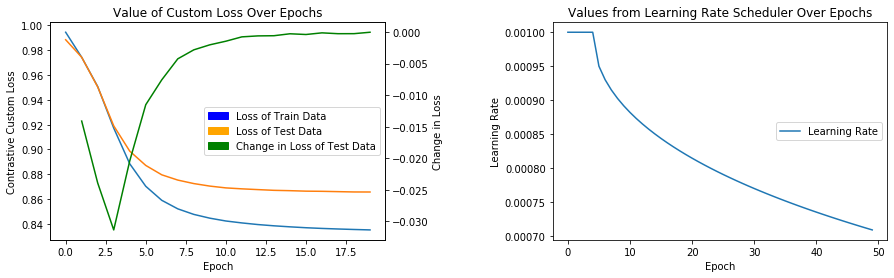

In [55]:
fig = plt.figure(figsize=(15,4))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(1,2,1)
pd.Series(hist.history['loss']).plot(ax=ax)
pd.Series(hist.history['val_loss']).plot(ax=ax)
ax1 = ax.twinx()
pd.Series(hist.history['val_loss']).diff().plot(ax=ax1, color="green")
l1 = mpatches.Patch(color="blue", label="Loss of Train Data")
l2 = mpatches.Patch(color="orange", label="Loss of Test Data")
l3 = mpatches.Patch(color="green", label="Change in Loss of Test Data")
plt.legend(handles=[l1,l2,l3], loc="center right")
ax1.set_ylabel("Change in Loss")
ax.set_ylabel("Contrastive Custom Loss")
ax.set_xlabel("Epoch")
plt.title("Value of Custom Loss Over Epochs")
plt.subplot(1,2,2)
pd.Series(np.arange(50)+1).apply(lrscheduler).plot(label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Values from Learning Rate Scheduler Over Epochs")
plt.legend(loc="center right")
plt.show()

<h2> Triplet Siamese Training </h2>